# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [ 0.04115733 -0.18489142 -0.00603261  0.31833058] 0 1.0 False {}
state, action, reward, done, info: [0.0374595  0.01031593 0.000334   0.02375131] 1 1.0 False {}
state, action, reward, done, info: [ 0.03766582  0.20543309  0.00080903 -0.26882622] 1 1.0 False {}
state, action, reward, done, info: [ 0.04177448  0.0102996  -0.00456749  0.02411177] 0 1.0 False {}
state, action, reward, done, info: [ 0.04198047  0.20548675 -0.00408526 -0.27000875] 1 1.0 False {}
state, action, reward, done, info: [ 0.04609021  0.40066676 -0.00948543 -0.56397738] 1 1.0 False {}
state, action, reward, done, info: [ 0.05410354  0.59592051 -0.02076498 -0.85963351] 1 1.0 False {}
state, action, reward, done, info: [ 0.06602195  0.79131905 -0.03795765 -1.15877258] 1 1.0 False {}
state, action, reward, done, info: [ 0.08184833  0.98691452 -0.0611331  -1.46311133] 1 1.0 False {}
state, action, reward, done, info: [ 0.10158662  1.18272995 -0.09039533 -1.77424773] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return actions, states, rewards, targetQs

In [7]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
# Discriminator: Discriminting/differentiating between real and fake/generated actions
def discriminator(actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_loss(actions, states, rewards, # Calculating Qs
               targetQs, # targetQs/nextQs
               action_size, hidden_size): # model init for Qs
        
    # # Calculate targetQs/nextQs
    # q_logits_fake = sess.run(model.q_logits_fake, feed_dict={model.states: states})            
    # rewarded_q_logits = np.multiply(q_logits_fake, np.reshape(rewards, [-1, 1]))
    # Qs = np.max(rewarded_q_logits, axis=1)
                
    # calculate Qs_fake
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    q_logits_fake = discriminator(actions=actions_logits, hidden_size=hidden_size)
    rewarded_q_logits_fake = tf.multiply(q_logits_fake, tf.reshape(rewards, shape=[-1, 1]))
    Qs_fake = tf.reduce_max(rewarded_q_logits_fake, axis=1)
    
    # calculate Qs_real
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    q_logits_real = discriminator(actions=actions_onehot, hidden_size=hidden_size, reuse=True)
    rewarded_q_logits_real = tf.multiply(q_logits_real, tf.reshape(rewards, shape=[-1, 1]))
    Qs_real = tf.reduce_max(rewarded_q_logits_real, axis=1)
    
    # Calculating the g_loss and d_loss
    # g_loss = tf.reduce_mean(tf.square(Qs_fake[:-1] - targetQs[1:]))
    # d_loss = tf.reduce_mean(tf.square(Qs_real[:-1] - targetQs[1:]))
    # g_loss += tf.reduce_mean(tf.square(Qs_real[:-1]))
    # d_loss += tf.reduce_mean(tf.square(Qs_fake[:-1]))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_fake[:-1], 
                                                                    labels=tf.nn.sigmoid(targetQs[1:])))
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_real[:-1], 
                                                                    labels=tf.nn.sigmoid(targetQs[1:])))
    g_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_real[:-1], 
                                                                    labels=tf.zeros_like(targetQs[1:])))
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_fake[:-1], 
                                                                    labels=tf.zeros_like(targetQs[1:])))
    
    return actions_logits, q_logits_fake, g_loss, d_loss

In [10]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for real and fake action discrimination
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.rewards, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_logits_fake, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            rewards=self.rewards, states=self.states, actions=self.actions, # Calculating Qs 
            targetQs=self.targetQs) # alculating targetQs/nextQs

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
print('state size:{}'.format(state.shape), 
      'action:{}'.format(action)) #(np.max(action) - np.min(action)+1)

state size:(4,) action:1


In [14]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [15]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
state, reward, action

(array([-0.03163551,  0.01056443,  0.00224937,  0.04901907]), 1.0, 0)

In [18]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
g_loss_list = [] # generator loss
d_loss_list = [] # discriminator loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        g_loss_batch = []
        d_loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            last_action_logits = actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            # Take new action, get new state and reward
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            
            # Calculate targetQs/nextQs
            q_logits_fake = sess.run(model.q_logits_fake, feed_dict={model.states: states})            
            rewarded_q_logits = np.multiply(q_logits_fake, np.reshape(rewards, [-1, 1]))
            Qs = np.max(rewarded_q_logits, axis=1)
    
            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.actions: actions,
                         model.states: states, 
                         model.rewards: rewards, 
                         model.targetQs: Qs} # labelQs
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)

            # For average loss in one episode/epoch
            g_loss_batch.append(g_loss)
            d_loss_batch.append(d_loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average g_loss: {:.4f}'.format(np.mean(g_loss_batch)),
              'Average d_loss: {:.4f}'.format(np.mean(d_loss_batch)),
              'Explore P: {:.4f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        g_loss_list.append((ep, np.mean(g_loss_batch)))
        d_loss_list.append((ep, np.mean(d_loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model2.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 14.0 Average g_loss: 1.2877 Average d_loss: 1.3069 Explore P: 0.9985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 14.0 Average g_loss: 1.0570 Average d_loss: 1.0918 Explore P: 0.9970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 19.0 Average g_loss: 0.6608 Average d_loss: 0.7120 Explore P: 0.9951
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 9.0 Average g_loss: 0.4336 Average d_loss: 0.4320 Explore P: 0.9941
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 19.0 Average g_loss: 0.2711 Average d_loss: 0.2620 Explore P: 0.9384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 30.0 Average g_loss: 0.2600 Average d_loss: 0.2514 Explore P: 0.9356
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 24.0 Average g_loss: 0.2582 Average d_loss: 0.2517 Explore P: 0.9333
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 9.0 Average g_loss: 0.2693 Average d_loss: 0.2644 Explore P: 0.9323
-------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 66 Total reward: 50.0 Average g_loss: 0.2293 Average d_loss: 0.2224 Explore P: 0.8710
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 16.0 Average g_loss: 0.2267 Average d_loss: 0.2172 Explore P: 0.8695
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 8.0 Average g_loss: 0.2240 Average d_loss: 0.2138 Explore P: 0.8688
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 18.0 Average g_loss: 0.2265 Average d_loss: 0.2180 Explore P: 0.8671
-------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 99 Total reward: 24.0 Average g_loss: 0.2890 Average d_loss: 0.2706 Explore P: 0.8214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 100 Total reward: 12.0 Average g_loss: 0.2982 Average d_loss: 0.2782 Explore P: 0.8203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 12.0 Average g_loss: 0.2978 Average d_loss: 0.2781 Explore P: 0.8192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 19.0 Average g_loss: 0.3053 Average d_loss: 0.2844 Explore P: 0.8176
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 132 Total reward: 12.0 Average g_loss: 0.2923 Average d_loss: 0.2789 Explore P: 0.7762
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 133 Total reward: 75.0 Average g_loss: 0.2885 Average d_loss: 0.2706 Explore P: 0.7704
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 10.0 Average g_loss: 0.2727 Average d_loss: 0.2523 Explore P: 0.7696
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 15.0 Average g_loss: 0.2812 Average d_loss: 0.2642 Explore P: 0.7684
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 166 Total reward: 12.0 Average g_loss: 0.3190 Average d_loss: 0.2916 Explore P: 0.7318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 11.0 Average g_loss: 0.3177 Average d_loss: 0.2982 Explore P: 0.7309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 10.0 Average g_loss: 0.3277 Average d_loss: 0.3056 Explore P: 0.7301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 15.0 Average g_loss: 0.3315 Average d_loss: 0.3025 Explore P: 0.7290
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 199 Total reward: 13.0 Average g_loss: 0.3494 Average d_loss: 0.3229 Explore P: 0.6983
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 200 Total reward: 17.0 Average g_loss: 0.3476 Average d_loss: 0.3224 Explore P: 0.6970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 11.0 Average g_loss: 0.3505 Average d_loss: 0.3243 Explore P: 0.6962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 11.0 Average g_loss: 0.3448 Average d_loss: 0.3139 Explore P: 0.6954
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 233 Total reward: 18.0 Average g_loss: 0.3232 Average d_loss: 0.3101 Explore P: 0.6624
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 19.0 Average g_loss: 0.3203 Average d_loss: 0.3045 Explore P: 0.6611
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 9.0 Average g_loss: 0.3195 Average d_loss: 0.2980 Explore P: 0.6604
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 236 Total reward: 9.0 Average g_loss: 0.3219 Average d_loss: 0.3001 Explore P: 0.6598
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 266 Total reward: 21.0 Average g_loss: 0.3816 Average d_loss: 0.3475 Explore P: 0.6338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 267 Total reward: 15.0 Average g_loss: 0.3727 Average d_loss: 0.3406 Explore P: 0.6328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 19.0 Average g_loss: 0.3701 Average d_loss: 0.3451 Explore P: 0.6316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 269 Total reward: 9.0 Average g_loss: 0.3688 Average d_loss: 0.3429 Explore P: 0.6310
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 300 Total reward: 11.0 Average g_loss: 0.3076 Average d_loss: 0.2925 Explore P: 0.5997
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 10.0 Average g_loss: 0.3090 Average d_loss: 0.2877 Explore P: 0.5990
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 16.0 Average g_loss: 0.3114 Average d_loss: 0.2871 Explore P: 0.5980
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 19.0 Average g_loss: 0.3166 Average d_loss: 0.2954 Explore P: 0.5969
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 333 Total reward: 9.0 Average g_loss: 0.3616 Average d_loss: 0.3381 Explore P: 0.5728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 334 Total reward: 8.0 Average g_loss: 0.3663 Average d_loss: 0.3428 Explore P: 0.5723
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 335 Total reward: 10.0 Average g_loss: 0.3652 Average d_loss: 0.3282 Explore P: 0.5717
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 336 Total reward: 10.0 Average g_loss: 0.3629 Average d_loss: 0.3224 Explore P: 0.5710
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 367 Total reward: 9.0 Average g_loss: 0.3682 Average d_loss: 0.3491 Explore P: 0.5466
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 17.0 Average g_loss: 0.3559 Average d_loss: 0.3339 Explore P: 0.5456
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 19.0 Average g_loss: 0.3586 Average d_loss: 0.3375 Explore P: 0.5445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 17.0 Average g_loss: 0.3503 Average d_loss: 0.3206 Explore P: 0.5436
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 401 Total reward: 15.0 Average g_loss: 0.3694 Average d_loss: 0.3429 Explore P: 0.5222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 402 Total reward: 14.0 Average g_loss: 0.3716 Average d_loss: 0.3456 Explore P: 0.5214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 403 Total reward: 11.0 Average g_loss: 0.3713 Average d_loss: 0.3367 Explore P: 0.5208
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 404 Total reward: 15.0 Average g_loss: 0.3633 Average d_loss: 0.3186 Explore P: 0.5200
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 435 Total reward: 16.0 Average g_loss: 0.3815 Average d_loss: 0.3570 Explore P: 0.4993
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 436 Total reward: 11.0 Average g_loss: 0.3755 Average d_loss: 0.3508 Explore P: 0.4987
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 437 Total reward: 8.0 Average g_loss: 0.3813 Average d_loss: 0.3646 Explore P: 0.4982
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 438 Total reward: 10.0 Average g_loss: 0.3822 Average d_loss: 0.3615 Explore P: 0.4977
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 468 Total reward: 11.0 Average g_loss: 0.4002 Average d_loss: 0.3759 Explore P: 0.4797
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 469 Total reward: 18.0 Average g_loss: 0.3961 Average d_loss: 0.3563 Explore P: 0.4788
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 470 Total reward: 12.0 Average g_loss: 0.3938 Average d_loss: 0.3333 Explore P: 0.4782
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 471 Total reward: 8.0 Average g_loss: 0.3870 Average d_loss: 0.3441 Explore P: 0.4777
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 502 Total reward: 11.0 Average g_loss: 0.3770 Average d_loss: 0.3376 Explore P: 0.4583
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 503 Total reward: 10.0 Average g_loss: 0.3729 Average d_loss: 0.3366 Explore P: 0.4578
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 504 Total reward: 11.0 Average g_loss: 0.3757 Average d_loss: 0.3556 Explore P: 0.4572
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 505 Total reward: 11.0 Average g_loss: 0.3797 Average d_loss: 0.3574 Explore P: 0.4567
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 535 Total reward: 8.0 Average g_loss: 0.3959 Average d_loss: 0.3672 Explore P: 0.4409
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 536 Total reward: 18.0 Average g_loss: 0.3977 Average d_loss: 0.3567 Explore P: 0.4401
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 537 Total reward: 15.0 Average g_loss: 0.4052 Average d_loss: 0.3876 Explore P: 0.4394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 538 Total reward: 13.0 Average g_loss: 0.3999 Average d_loss: 0.3706 Explore P: 0.4388
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 568 Total reward: 12.0 Average g_loss: 0.4056 Average d_loss: 0.3660 Explore P: 0.4240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 569 Total reward: 10.0 Average g_loss: 0.4027 Average d_loss: 0.3666 Explore P: 0.4236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 570 Total reward: 15.0 Average g_loss: 0.4044 Average d_loss: 0.3658 Explore P: 0.4229
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 571 Total reward: 10.0 Average g_loss: 0.4075 Average d_loss: 0.3632 Explore P: 0.4224
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 601 Total reward: 12.0 Average g_loss: 0.4079 Average d_loss: 0.3923 Explore P: 0.4076
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 11.0 Average g_loss: 0.4129 Average d_loss: 0.4045 Explore P: 0.4071
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 603 Total reward: 8.0 Average g_loss: 0.4064 Average d_loss: 0.3761 Explore P: 0.4068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 604 Total reward: 7.0 Average g_loss: 0.4206 Average d_loss: 0.3956 Explore P: 0.4065
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 634 Total reward: 16.0 Average g_loss: 0.4116 Average d_loss: 0.3593 Explore P: 0.3931
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 635 Total reward: 9.0 Average g_loss: 0.4187 Average d_loss: 0.3862 Explore P: 0.3927
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 636 Total reward: 9.0 Average g_loss: 0.4221 Average d_loss: 0.4018 Explore P: 0.3923
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 637 Total reward: 15.0 Average g_loss: 0.4181 Average d_loss: 0.3970 Explore P: 0.3917
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 667 Total reward: 11.0 Average g_loss: 0.4195 Average d_loss: 0.3816 Explore P: 0.3787
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 668 Total reward: 9.0 Average g_loss: 0.4187 Average d_loss: 0.3868 Explore P: 0.3783
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 13.0 Average g_loss: 0.4214 Average d_loss: 0.3849 Explore P: 0.3778
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 9.0 Average g_loss: 0.4254 Average d_loss: 0.3898 Explore P: 0.3775
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 700 Total reward: 7.0 Average g_loss: 0.4194 Average d_loss: 0.3677 Explore P: 0.3651
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 701 Total reward: 8.0 Average g_loss: 0.4220 Average d_loss: 0.3791 Explore P: 0.3648
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 702 Total reward: 10.0 Average g_loss: 0.4221 Average d_loss: 0.4003 Explore P: 0.3644
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 703 Total reward: 14.0 Average g_loss: 0.4206 Average d_loss: 0.3844 Explore P: 0.3639
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 734 Total reward: 9.0 Average g_loss: 0.4322 Average d_loss: 0.4038 Explore P: 0.3516
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 735 Total reward: 12.0 Average g_loss: 0.4338 Average d_loss: 0.3894 Explore P: 0.3511
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 736 Total reward: 8.0 Average g_loss: 0.4336 Average d_loss: 0.4069 Explore P: 0.3508
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 737 Total reward: 14.0 Average g_loss: 0.4351 Average d_loss: 0.4025 Explore P: 0.3503
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 767 Total reward: 9.0 Average g_loss: 0.3996 Average d_loss: 0.3474 Explore P: 0.3383
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 768 Total reward: 11.0 Average g_loss: 0.4029 Average d_loss: 0.3372 Explore P: 0.3379
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 769 Total reward: 12.0 Average g_loss: 0.4097 Average d_loss: 0.3721 Explore P: 0.3374
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 770 Total reward: 9.0 Average g_loss: 0.4133 Average d_loss: 0.3636 Explore P: 0.3371
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 801 Total reward: 9.0 Average g_loss: 0.4266 Average d_loss: 0.3967 Explore P: 0.3261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 802 Total reward: 13.0 Average g_loss: 0.4229 Average d_loss: 0.3907 Explore P: 0.3257
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 803 Total reward: 18.0 Average g_loss: 0.4250 Average d_loss: 0.3987 Explore P: 0.3251
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 804 Total reward: 11.0 Average g_loss: 0.4152 Average d_loss: 0.3621 Explore P: 0.3247
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 834 Total reward: 10.0 Average g_loss: 0.4370 Average d_loss: 0.4102 Explore P: 0.3144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 835 Total reward: 14.0 Average g_loss: 0.4428 Average d_loss: 0.4157 Explore P: 0.3139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 836 Total reward: 11.0 Average g_loss: 0.4343 Average d_loss: 0.4138 Explore P: 0.3136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 837 Total reward: 12.0 Average g_loss: 0.4237 Average d_loss: 0.3819 Explore P: 0.3132
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 867 Total reward: 9.0 Average g_loss: 0.4305 Average d_loss: 0.3792 Explore P: 0.3035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 868 Total reward: 9.0 Average g_loss: 0.4359 Average d_loss: 0.4023 Explore P: 0.3032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 869 Total reward: 17.0 Average g_loss: 0.4357 Average d_loss: 0.4016 Explore P: 0.3027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 870 Total reward: 9.0 Average g_loss: 0.4346 Average d_loss: 0.3992 Explore P: 0.3024
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 901 Total reward: 7.0 Average g_loss: 0.4284 Average d_loss: 0.3879 Explore P: 0.2923
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 902 Total reward: 11.0 Average g_loss: 0.4446 Average d_loss: 0.4189 Explore P: 0.2920
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 903 Total reward: 13.0 Average g_loss: 0.4257 Average d_loss: 0.3706 Explore P: 0.2916
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 904 Total reward: 10.0 Average g_loss: 0.4331 Average d_loss: 0.3834 Explore P: 0.2913
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 935 Total reward: 9.0 Average g_loss: 0.4411 Average d_loss: 0.3991 Explore P: 0.2819
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 936 Total reward: 12.0 Average g_loss: 0.4498 Average d_loss: 0.4338 Explore P: 0.2816
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 9.0 Average g_loss: 0.4578 Average d_loss: 0.4384 Explore P: 0.2813
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 938 Total reward: 8.0 Average g_loss: 0.4367 Average d_loss: 0.3912 Explore P: 0.2811
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 968 Total reward: 10.0 Average g_loss: 0.4322 Average d_loss: 0.4133 Explore P: 0.2717
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 969 Total reward: 13.0 Average g_loss: 0.4444 Average d_loss: 0.4361 Explore P: 0.2713
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 970 Total reward: 11.0 Average g_loss: 0.4172 Average d_loss: 0.3769 Explore P: 0.2710
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 971 Total reward: 7.0 Average g_loss: 0.4134 Average d_loss: 0.3834 Explore P: 0.2708
---------------------------------------------------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

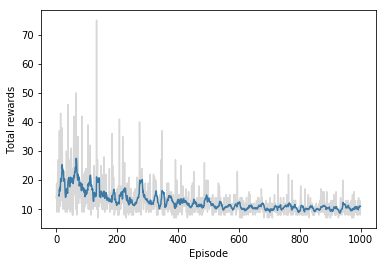

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average g_losses')

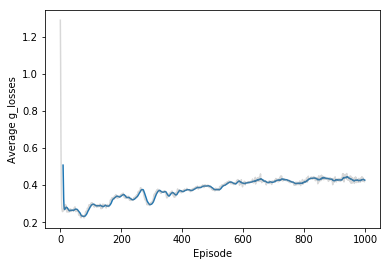

In [24]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average g_losses')

Text(0,0.5,'Average d_losses')

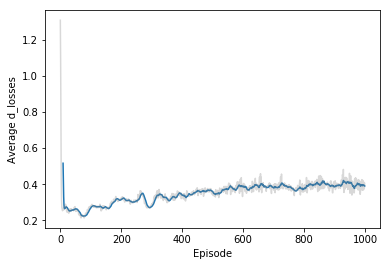

In [22]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average d_losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.